In [2]:
from qiskit import qiskit
from numpy import pi
from myQFT import myQFT
from binToDez import binToDez, dezToBin
from gcd import gcd

In [71]:
def P_Gate(theta: float, controls: int = 0) -> qiskit.circuit.library.standard_gates.PhaseGate:
    """Returns a Phase Gate with *controls* many controlled inputs
        A single Qubit Phase Gate looks like this:
        ( 1        0     )
        ( 0  e^(i*theta) )

    Parameters:
    theta: float
        determines the phase shift
    controls: int
        defines the amount of control bits. Default = 0

    Returns: Phase Gate with *controls* many controlled inputs
    """
    if controls > 0:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(controls)
    else:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta)))

def calculate_A_Gate(target_bit_index: int,a_bin: list[int]) -> qiskit.circuit.library.standard_gates.PhaseGate:
    """Returns an Addition Gate for the quantum Addition as descriped by Beauregard(Stêphane Beauregard, Circuit for Shor’s algorithm using 2n+3 qubits, https://arxiv.org/pdf/quant-ph/0205095.pdf) 
        Infact this is a Phase Gate with added up theta's depending/controlled by the binary representation of the classically summand(a)
        The Gate operates on n+1 Qubits b contraining a n bit number to prevent overflow. So the input(before QFT) for the MSB should be |0>

    Parameters:
    target_bit_index: int
        Index of the target Qubit of the Quantum summand b. The Most significant Bit should be index 0 while the last element/Least significant Bit should have index n-1 while having a whole of n qubits.
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.

    Returns: single Qubit Phase Gate 
    """
    theta, exponent, index_controller_bit = 0.0, 1, target_bit_index
    for _ in range(target_bit_index, len(a_bin)):
        if a_bin[index_controller_bit] == 1:
            theta+= 2*pi/(2**(exponent))
        exponent+=1
        index_controller_bit+=1
    return P_Gate(theta)

def quantum_classical_addition_Gate(a_bin: list[int]) -> qiskit.circuit.gate:
    """Creates a combination of A/Phase Gates which allow an addition of classical bits to a quantum register.

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.

    Returns: Addition Gate
    """
    A_circuit = qiskit.QuantumCircuit(len(a_bin))
    for index in range(len(a_bin)):
        A_circuit.append(calculate_A_Gate(index,a_bin),[index])
    A_circuit = A_circuit.to_gate()
    A_circuit.name = "Add with " + str(binToDez(a_bin))
    return A_circuit

#Qubit 0,1 control, last qubit ancilla
def modular_adder_gate(a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.quantumcircuit:
    """Creates a modular adder Gate as an qiskit.circuit.quantumcircuit class. performs a+b Mod N in the fourier space. a is added classically while b is given as Qubits.
        The Gate has a total of 2 + len(a_bin) + 1 Qubits. The first ones are controll qubits, the varaible input is the lenght of the b qubits which needs to be the same as as len(a_bin).
        The last

        Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.
    N_bin: list[int]
        Binary representation of the divisor N of the Modulo operation. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.

    Returns: Modular adder gate as quantumcircuit
    """
    mod_add_gate = qiskit.QuantumCircuit(len(a_bin)+3)
    mod_add_gate.append(quantum_classical_addition_Gate(a_bin).control(2),[0,1] + list(range(2,len(a_bin)+2)))
    mod_add_gate.append(quantum_classical_addition_Gate(N_bin).inverse(),list(range(2,len(a_bin)+2)))
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)),inverse= True)
    mod_add_gate.cnot(2,len(a_bin)+2)
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)))
    mod_add_gate.append(quantum_classical_addition_Gate(N_bin).control(1),[len(a_bin)+2] + list(range(2,len(a_bin)+2)))
    #mod_add_gate.reset(len(a_bin)+2) #'One or more instructions cannot be converted to a gate. "reset" is not a gate instruction', verhindert Erstellung eines Gates. Komplexere Lösung des Qubit reset möglich
    mod_add_gate.append(quantum_classical_addition_Gate(a_bin).control(2).inverse(),[0,1] + list(range(2,len(a_bin)+2)))
    mod_add_gate.name = "Add with " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)),inverse= True)
    mod_add_gate.x(2)
    mod_add_gate.cnot(2,len(a_bin)+2)
    mod_add_gate.x(2)
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)))
    mod_add_gate.append(quantum_classical_addition_Gate(a_bin).control(2),[0,1] + list(range(2,len(a_bin)+2)))
    return mod_add_gate
    

def controlled_multiplier_gate(a_bin: list[int],N_bin: list[int],x: int) -> qiskit.circuit.quantumcircuit:
    """
    Returns the controlled_multiplier_gate
    The gate takes 1 (c) + x many control Qubits on index 0 to len(x). The x controll bits represent the multiplier in (b+a*x) Mod N. The first bit of x is the MSB while the last is the LSB, so the second bit(the bit after c ) is MSB of the whole x register. 
    The gate needs one ancilla qubit for the underlying gates. This is the last Qubit of this Circuite
    """
    a_dez = binToDez(a_bin)
    N_dez = binToDez(N_bin)
    #Creates Circuite with 1 + x controll Quits and len(a_bin) (which should be the same as len(b_bin)) many input qubits + 1 ancilla Qubit for the modular adder

    
    cmult_mod_gate = qiskit.QuantumCircuit(1 + x + len(a_bin) + 1,4)
    ##
    cmult_mod_gate.x(0)
    cmult_mod_gate.x(3)
    cmult_mod_gate.x(9)
    ##
    myQFT(cmult_mod_gate,list(range(1+x,1+x+len(a_bin))))
    #exponent = x
    for control in range(1, 1 + x):
        a = int(a_dez * (2**(control-1))) % N_dez#a = int(a_dez * (2**(exponent-1))) % N_dez
        #exponent-=1
        summand = dezToBin(a, len(a_bin))
        cmult_mod_gate.append(modular_adder_gate(summand,N_bin),[0] + [control] + list(range(1+x,1+x+len(a_bin)+ 1)))
    myQFT(cmult_mod_gate,list(range(1+x,1+x+len(a_bin))),inverse= True)
    cmult_mod_gate.name = "CMULT " + str(a_dez) + " mod " + str(N_dez)
    return cmult_mod_gate

#Index 0 ist Controll .Indexes 1 bis x für X bits. x+1 bis 2x +1 sind |0> Bits, 2x+2 Bit bzw letztes ist das Ancilla Qubit
def controlled_Ua_gate(a_bin: list[int],N_bin: list[int],x: int) -> qiskit.circuit.quantumcircuit:
    a_dez = binToDez(a_bin)
    a_dez_inv = gcd(a_dez, binToDez(N_bin))
    controlled_Ua_gate = qiskit.QuantumCircuit(1 + x + len(a_bin) + 1,4)
    ###
    controlled_Ua_gate.x(0)
    #controlled_Ua_gate.x(3)
    controlled_Ua_gate.x(4)
    ###
    controlled_Ua_gate.append(controlled_multiplier_gate(a_bin,N_bin,x),list(range(1 + x + len(a_bin) + 1)))
    for i in range(1,1+x):
        controlled_Ua_gate.swap(i,i+x+1)
    controlled_Ua_gate.append(controlled_multiplier_gate(dezToBin(a_dez_inv,len(a_bin)),N_bin,x).inverse(),list(range(1 + x + len(a_bin) + 1)))
    controlled_Ua_gate.name = "U_a^" + str(a_dez)
    return controlled_Ua_gate

In [53]:
qc = controlled_Ua_gate([0,0,1,1,1],[0,1,1,1,1],4)
qc.measure([1,2,3,4],[3,2,1,0])
qc.draw()

CircuitError: 'The amount of clbit arguments 0 does not match the instruction expectation (4).'

In [5]:
from qiskit.visualization import plot_histogram

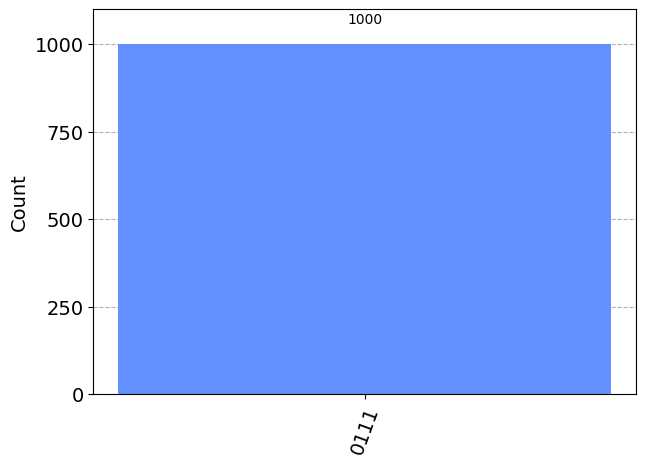

In [46]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

In [72]:
qc = controlled_multiplier_gate([0,0,1,1,1],[0,1,1,1,1],4)
qc.measure([6,7,8,9],[3,2,1,0])
qc.draw()

┌───┐                                                                 »
 q_0: ┤ X ├─────────────────────────────────────────────────────────────────»
      └───┘                                                                 »
 q_1: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 q_2: ──────────────────────────────────────────────────────────────────────»
      ┌───┐                                                                 »
 q_3: ┤ X ├─────────────────────────────────────────────────────────────────»
      └───┘                                                                 »
 q_4: ──────────────────────────────────────────────────────────────────────»
      ┌───┐                                                                 »
 q_5: ┤ H ├─■────────■─────────────■─────────────────■──────────────────────»
      └───┘ │P(π/2)  │       ┌───┐ │                 │                      »
 q_6: ──────■────────┼───────┤ H ├─┼────────■────────┼─────────■────────────»
                     │P(π/4) └───┘ │        │P(π/2)  │         │       ┌───┐»
 q_7: ───────────────■─────────────┼────────■────────┼─────────┼───────┤ H ├»
                                   │P(π/8)           │         │P(π/4) └───┘»
 q_8: ─────────────────────────────■─────────────────┼─────────■────────────»
      ┌───┐                                          │P(π/16)               »
 q_9: ┤ X ├──────────────────────────────────────────■──────────────────────»
      └───┘                                                                 »
q_10: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 c: 4/══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                    ┌────────────────────┐»
« q_0: ──────────────────────────────────────────────┤0                   ├»
«                                                    │                    │»
« q_1: ──────────────────────────────────────────────┤1                   ├»
«                                                    │                    │»
« q_2: ──────────────────────────────────────────────┤                    ├»
«                                                    │                    │»
« q_3: ──────────────────────────────────────────────┤                    ├»
«                                                    │                    │»
« q_4: ──────────────────────────────────────────────┤                    ├»
«                                                    │                    │»
« q_5: ──────────────────────────────────────────────┤2 Add with 7 Mod 15 ├»
«                                                    │                    │»
« q_6: ─■────────────────────────────────────────────┤3                   ├»
«       │                                            │                    │»
« q_7: ─┼────────■────────■──────────────────────────┤4                   ├»
«       │        │P(π/2)  │       ┌───┐              │                    │»
« q_8: ─┼────────■────────┼───────┤ H ├─■────────────┤5                   ├»
«       │P(π/8)           │P(π/4) └───┘ │P(π/2) ┌───┐│                    │»
« q_9: ─■─────────────────■─────────────■───────┤ H ├┤6                   ├»
«                                               └───┘│                    │»
«q_10: ──────────────────────────────────────────────┤7                   ├»
«                                                    └────────────────────┘»
« c: 4/════════════════════════════════════════════════════════════════════»
«                                                                          »
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
« q_0: ┤0                    ├┤0                    ├

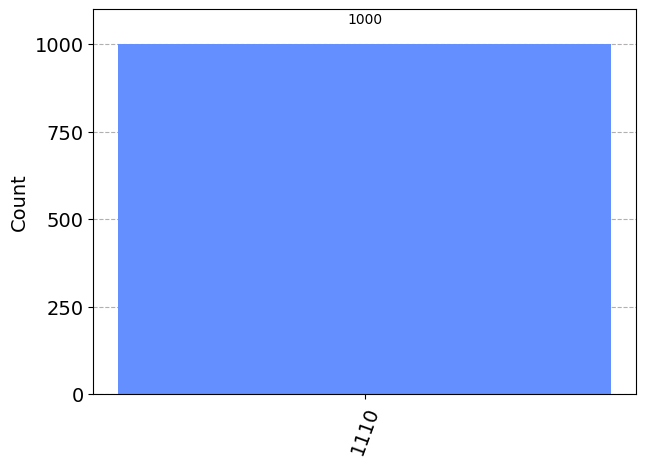

In [73]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)